# Proyek Klasifikasi Gambar: [Klasifikasi Boot, Shoe, Sandal]
- **Nama:** Evi Afiyatus Solihah
- **Email:** eviafiyatuss@gmail.com
- **ID Dicoding:** MC299D5X1752

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# menonaktifkan warning yang mungkin muncul, seperti warning FutureWarning.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eviafiyatus","key":"1c589be636b2247f76c6e97cf60fd0df"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflatin

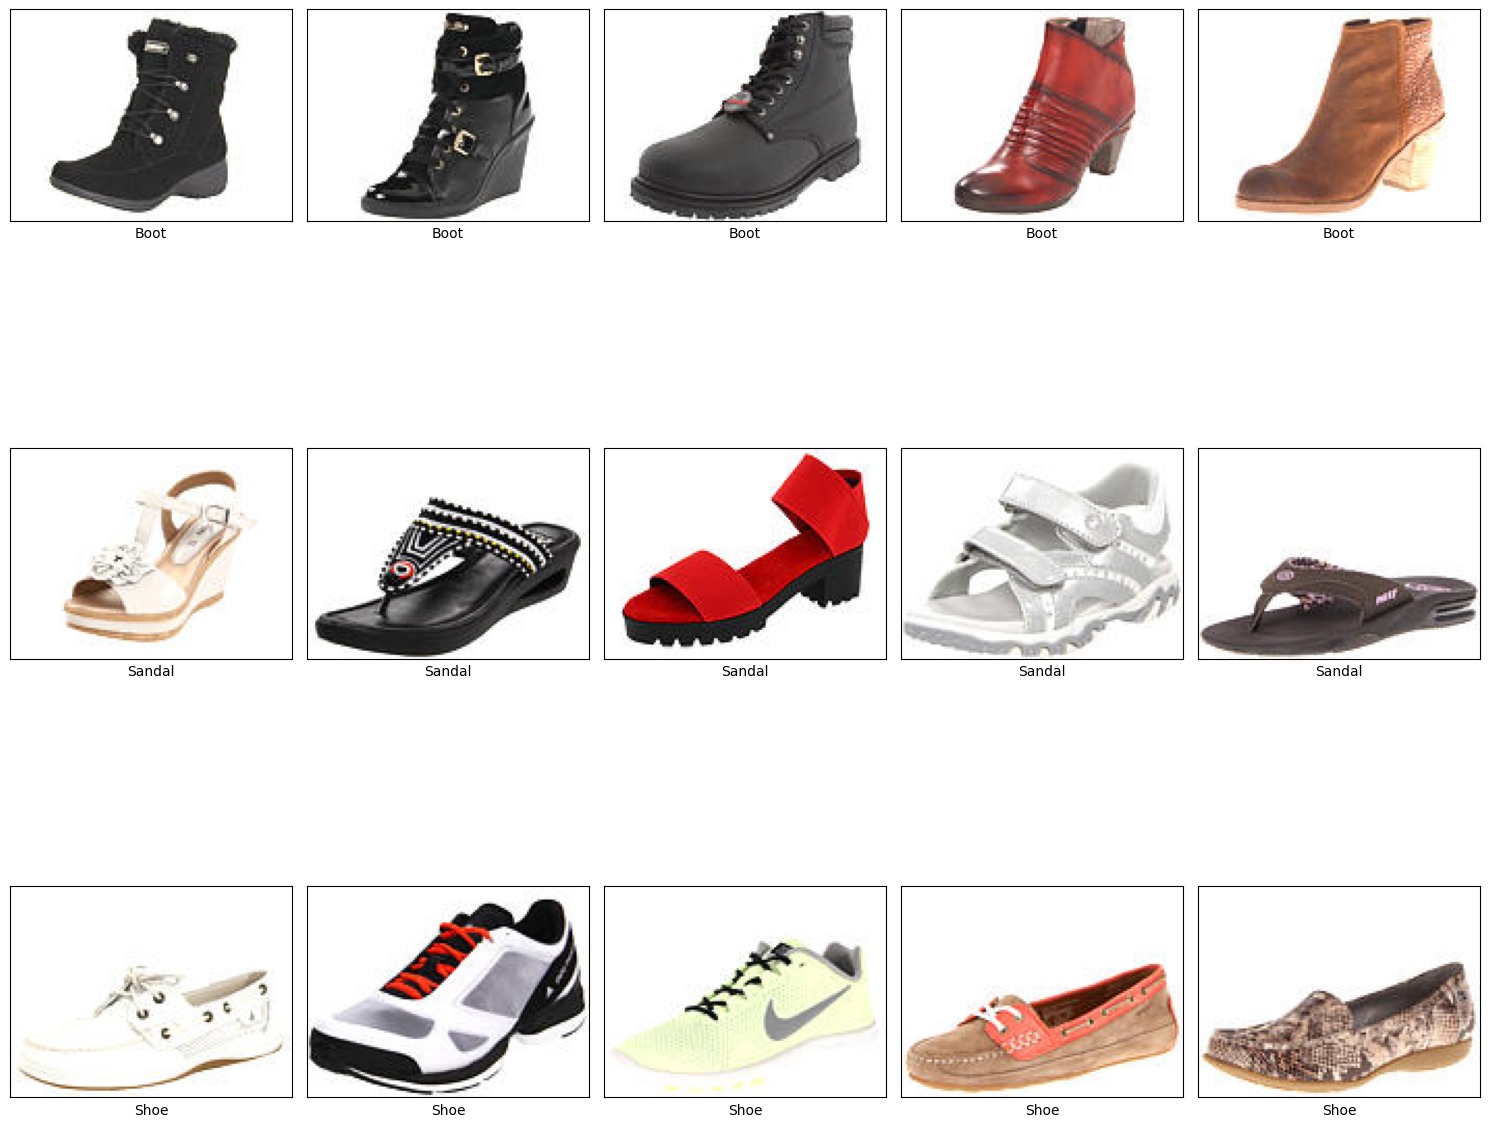

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "Shoe vs Sandal vs Boot Dataset/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path = "Shoe vs Sandal vs Boot Dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

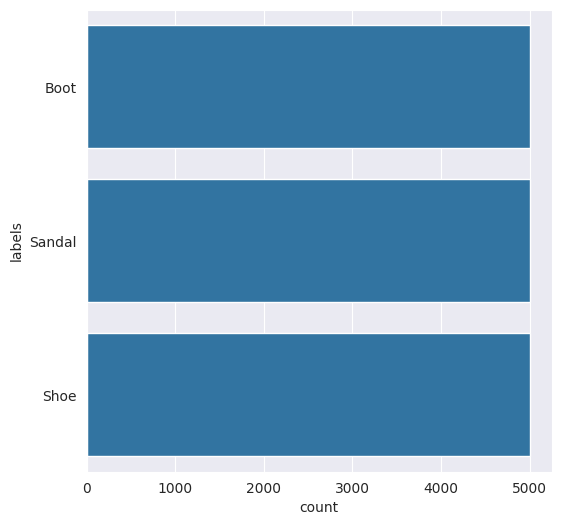

In [6]:
# Definisikan path sumber
lung_path = "Shoe vs Sandal vs Boot Dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [7]:
# Definisikan direktori utama
BASE_DIR = "Shoe vs Sandal vs Boot Dataset/"

# Path ke masing-masing kelas
boot_dir = os.path.join(BASE_DIR, 'Boot')
sandal_dir = os.path.join(BASE_DIR, 'Sandal')
shoe_dir = os.path.join(BASE_DIR, 'Shoe')

# Print jumlah gambar di masing-masing folder
print("Total number of Boot images: ", len(os.listdir(boot_dir)))
print("Total number of Sandal images: ", len(os.listdir(sandal_dir)))
print("Total number of Shoe images: ", len(os.listdir(shoe_dir)))

Total number of Boot images:  5000
Total number of Sandal images:  5000
Total number of Shoe images:  5000


#### Split Dataset

In [8]:
# Splitting dataset (Train, Val, Test) dengan proporsi 80:10:10
dataset_path = 'Shoe vs Sandal vs Boot Dataset/'
base_output = 'split_dataset'

split_ratio = {
    'train': 0.7,
    'val': 0.2,
    'test': 0.1
}

# Buat direktori output
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)

# Proses untuk setiap kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy ke folder tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

In [9]:
for split in ['train', 'val', 'test']:
    total = 0
    print(f"\nJumlah gambar di {split}:")
    split_path = os.path.join(base_output, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        num_images = len(os.listdir(class_dir))
        total += num_images
        print(f"  {class_name}: {num_images} gambar")
    print(f"Total {split}: {total} gambar")


Jumlah gambar di train:
  Boot: 3500 gambar
  Sandal: 3500 gambar
  Shoe: 3500 gambar
Total train: 10500 gambar

Jumlah gambar di val:
  Boot: 1000 gambar
  Sandal: 1000 gambar
  Shoe: 1000 gambar
Total val: 3000 gambar

Jumlah gambar di test:
  Boot: 500 gambar
  Sandal: 500 gambar
  Shoe: 500 gambar
Total test: 1500 gambar


In [10]:
# Detail komposisi Splitting Data
base_dir = 'split_dataset'
img_size = (150, 150)
batch_size = 32

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

#Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 10500 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [11]:
print("Daftar label dan index:")
for i, label in enumerate(train_ds.class_names):
    print(f"{i}: {label}")

Daftar label dan index:
0: Boot
1: Sandal
2: Shoe


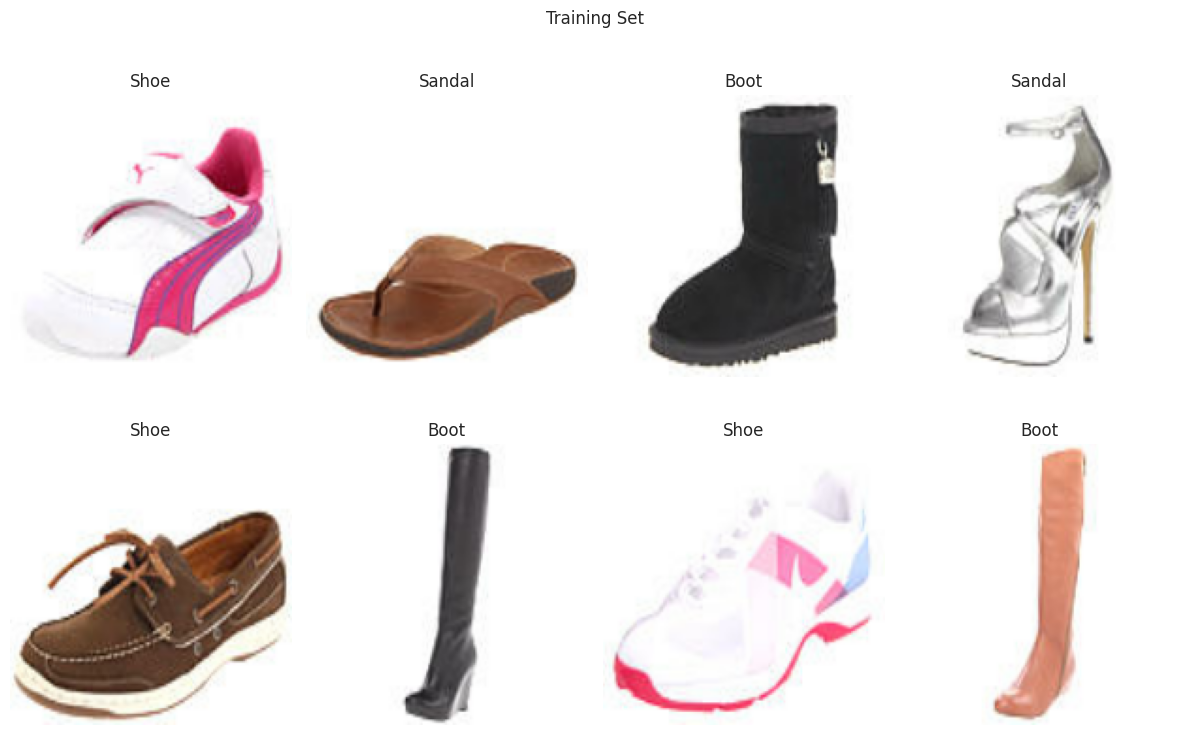

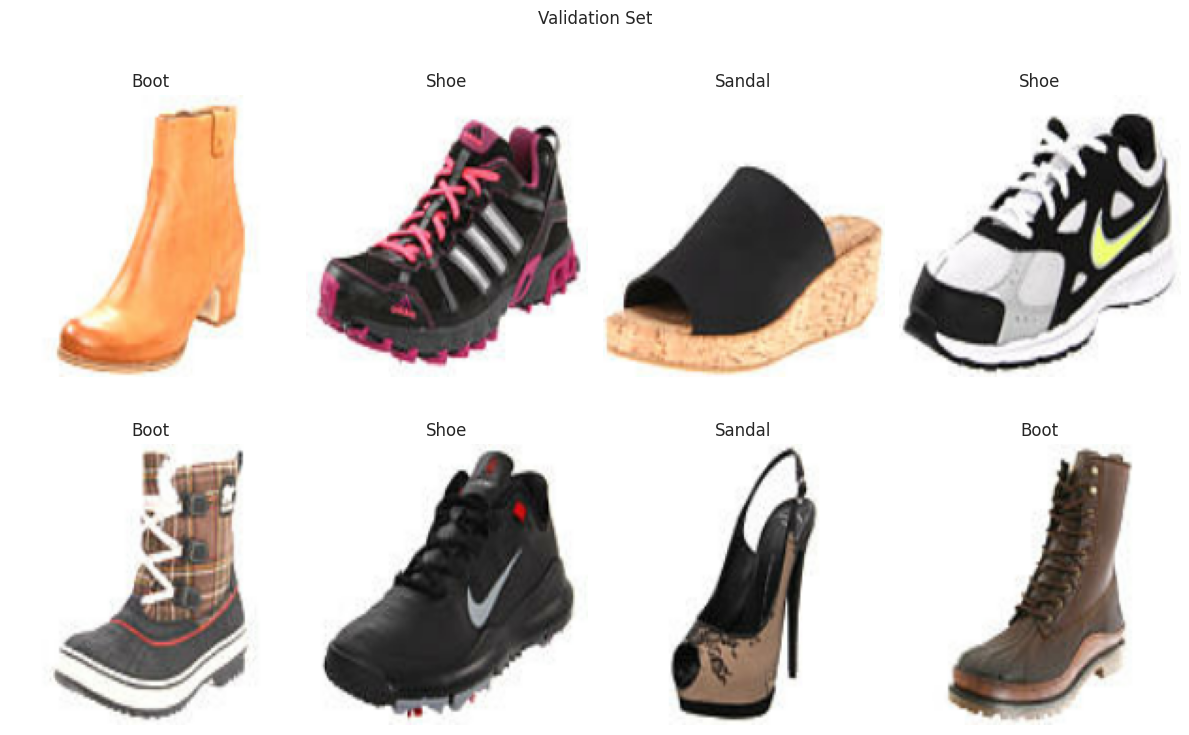

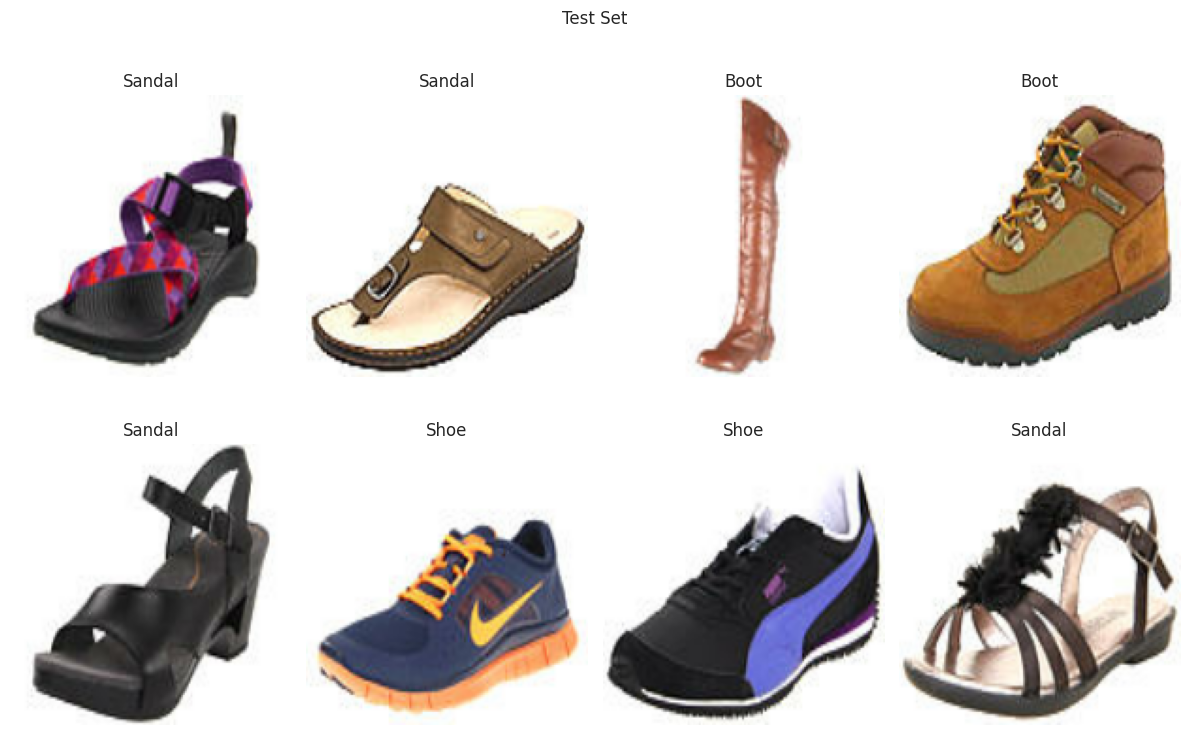

In [12]:
# Visualisasi sample foto pada masing masing split
class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

## Modelling

In [13]:
num_classes = len(class_names)

In [14]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential

# Aktifkan mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load model pretrained MobileNetV2
pre_trained_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3)
)

# Nonaktifkan training pada semua layer MobileNetV2
for layer in pre_trained_model.layers:
    layer.trainable = False

# Bangun model lengkap
model = Sequential([
    pre_trained_model,                    # Backbone dari pretrained model
    GlobalAveragePooling2D(),            # Pooling global untuk fitur kompak
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Kelas terakhir dengan dtype float32 agar aman di mixed precision
    Dense(num_classes, activation='softmax', dtype='float32')
])

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur
model.summary()

/tmp/ipython-input-14-1608909525.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Callback
checkpoint = ModelCheckpoint("saved_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

callbacks_list = [checkpoint, early_stop]

In [16]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list
)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.6716 - loss: 0.7706 - val_accuracy: 0.8887 - val_loss: 0.2973
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8586 - loss: 0.3675 - val_accuracy: 0.8990 - val_loss: 0.2576
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8719 - loss: 0.3313 - val_accuracy: 0.9230 - val_loss: 0.2021
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8848 - loss: 0.3028 - val_accuracy: 0.9297 - val_loss: 0.2011
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8933 - loss: 0.2776 - val_accuracy: 0.9350 - val_loss: 0.1906
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8996 - loss: 0.2595 - val_accuracy: 0.9167 - val_loss: 0.2101
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9032 - loss: 0.2613 - val_accuracy: 0.9373 - val_loss: 0.1716
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9095 - loss: 0.2369 - val_a

## Evaluasi dan Visualisasi

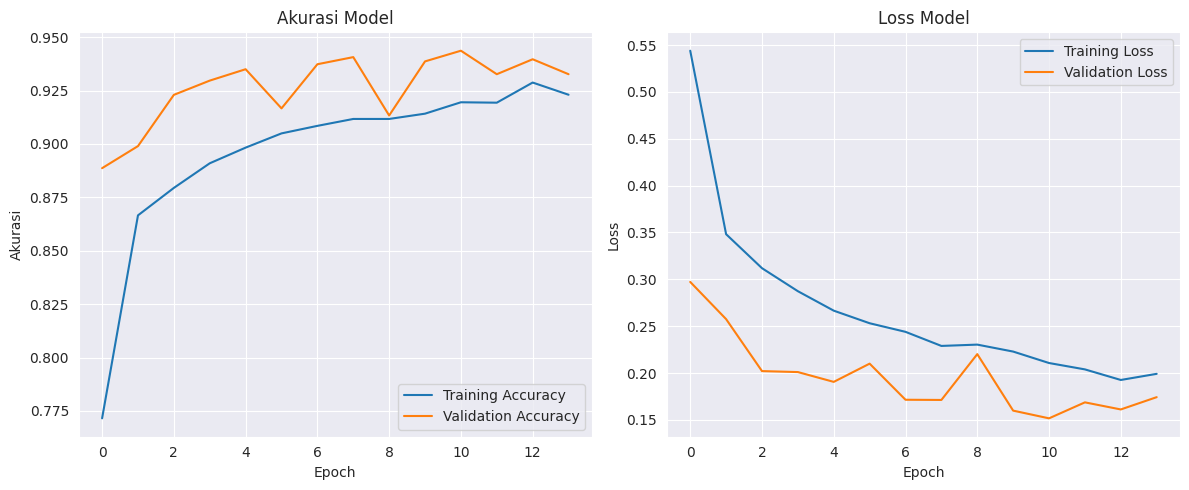

In [17]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
train_loss, train_acc = model.evaluate(train_ds)
print(f"Akurasi di train set: {train_acc:.2%}")

329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9486 - loss: 0.1305
Akurasi di train set: 95.24%


In [20]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Akurasi di val set: {val_acc:.2%}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9493 - loss: 0.1423
Akurasi di val set: 94.37%


In [21]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9334 - loss: 0.1677
Akurasi di test set: 92.93%


## Konversi Model

In [22]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


**Format Saved Model**

In [23]:
# Konversi model ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float16, name='keras_tensor_155')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134214114938512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124616208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124815952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124816528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124816144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124816336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124616592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214113199120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124617168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214124617552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134214113200656

**Format TFJS**

In [25]:
# Install TensorFlow.js converter
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [26]:
# Import library tensorflowjs
import tensorflowjs as tfjs

# Buat direktori untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Simpan model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


**Format TF-Lite**

In [27]:
# Konversi model SavedModel ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True  # Gunakan converter baru berbasis MLIR
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,   # Mendukung operasi standar TensorFlow Lite
    tf.lite.OpsSet.SELECT_TF_OPS      # Mendukung operasi TensorFlow tambahan
]
tflite_model = converter.convert()

# Membuat folder 'tflite'
os.makedirs("tflite", exist_ok=True)

# Menyimpan model yang sudah dikonversi ke dalam file .tflite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Menyimpan daftar label ke dalam file label.txt
labels = ["Boot", "Shoe", "Sandal"]
label_path = os.path.join("tflite", "label.txt")

with open(label_path, "w") as f:
    for label in labels:
        f.write(f"{label}\n")

**Menyimpan semua format Model**

In [28]:
from google.colab import files

# Zip semua model yang disimpan
!zip -r model_artifacts.zip saved_model tfjs_model tflite
# Download hasil zip
files.download("model_artifacts.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 9%)
  adding: tflite/label.txt (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [32]:
# Load model dari folder SavedModel
model = tf.keras.models.load_model('saved_model.keras', compile=False)

In [39]:
# Upload file gambar (misal .jpg)
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving boot.jpg to boot.jpg


In [40]:
# # Load gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Menambahkan batch dimension

# Prediksi
predictions = model.predict(img_array)

# Melihat probabilitas untuk setiap kelas
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[9.9912566e-01 2.8948838e-04 5.8481278e-04]]


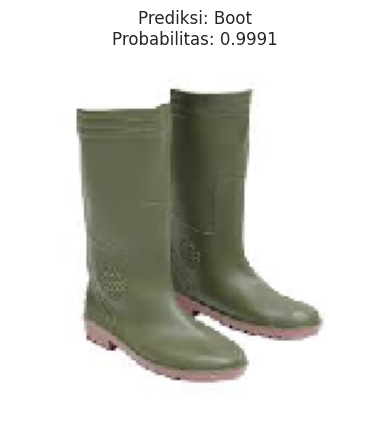

In [41]:
# Menentukan label untuk setiap kelas
class_labels = ['Boot', 'Shoe', 'Sandal']  # Ganti dengan label kelas yang sesuai

# Mengambil kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions, axis=1)
predicted_label = class_labels[predicted_class[0]]

# Menampilkan gambar
plt.imshow(img)
plt.axis('off')  # Menyembunyikan axis
plt.title(f"Prediksi: {predicted_label}\nProbabilitas: {predictions[0][predicted_class[0]]:.4f}")
plt.show()

In [42]:
print("Predicted class index:", predicted_class[0])
print("Full prediction output:", predictions)

Predicted class index: 0
Full prediction output: [[9.9912566e-01 2.8948838e-04 5.8481278e-04]]
